# Exploring the solution object

TBD.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import ivpsolve, recipes

backend.select("jax")  # ivp examples in jax


config.update("jax_enable_x64", True)

In [2]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.sir(time_span=(0.0, 50.0))


@jax.jit
def vector_field(y, *, t, p):
    return f(y, *p)


# Make a solver
solver, info_op = recipes.dynamic_isotropic_eks0(num_derivatives=2)

In [3]:
%%time
solution = ivpsolve.solve(
    vector_field,
    initial_values=(u0,),
    t0=t0,
    t1=t1,
    solver=solver,
    info_op=info_op,
    parameters=f_args,
    atol=1e-1,
    rtol=1e-1,
)

CPU times: user 1.99 s, sys: 2.99 ms, total: 1.99 s
Wall time: 1.95 s


In [4]:
# Look at the solution
print(len(solution))
print()
# print(solution[-1])

17



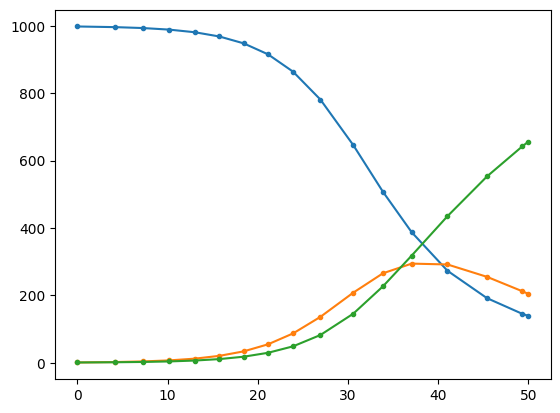

In [5]:
# Plot the solution
plt.plot(solution.t, solution.u, ".-")
plt.show()

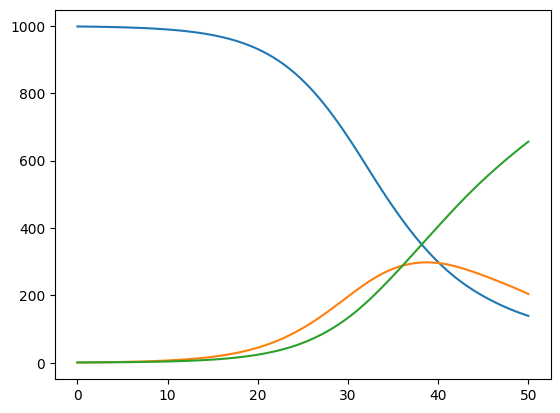

In [6]:
# Dense output

ts = jnp.linspace(t0 + 1e-3, t1 - 1e-3, num=100)
dense = solver.offgrid_marginals_searchsorted(ts=ts, solution=solution)

plt.plot(dense.t, dense.u)
plt.show()

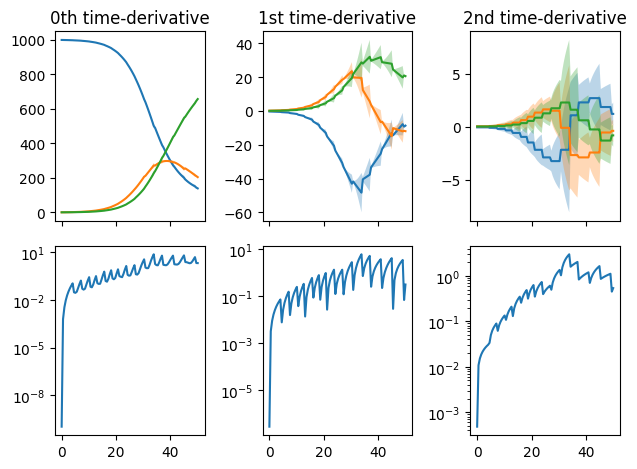

In [7]:
_, num_derivatives, _ = dense.marginals.mean.shape


fig, axes_all = plt.subplots(
    nrows=2, ncols=num_derivatives, sharex=True, tight_layout=True
)

for i, axes_cols in enumerate(axes_all.T):
    ms = dense.marginals_filtered.mean[:, i, :]
    ls = dense.marginals_filtered.cov_sqrtm_lower[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    if i == 1:
        axes_cols[0].set_title(f"{i}st time-derivative")
    elif i == 2:
        axes_cols[0].set_title(f"{i}nd time-derivative")
    elif i == 3:
        axes_cols[0].set_title(f"{i}rd time-derivative")
    else:
        axes_cols[0].set_title(f"{i}th time-derivative")

    axes_cols[0].plot(dense.t, ms)
    for m in ms.T:
        axes_cols[0].fill_between(dense.t, m - 1.96 * stds, m + 1.96 * stds, alpha=0.3)

    axes_cols[1].semilogy(dense.t, stds)

plt.show()

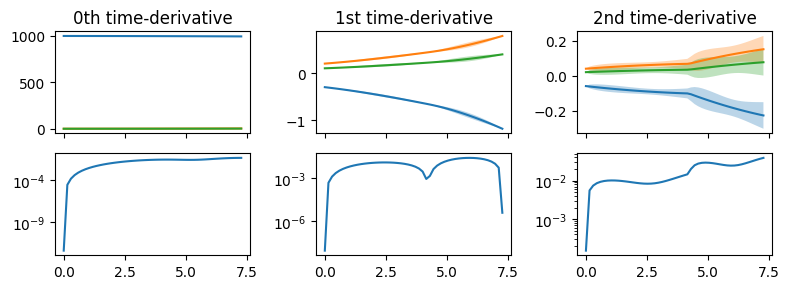

In [13]:
solution_small = solution[0:3]
ts = jnp.linspace(solution_small.t[0] + 1e-4, solution_small.t[-1] - 1e-4)

with jax.disable_jit():
    dense = solver.offgrid_marginals_searchsorted(ts=ts, solution=solution_small)


_, num_derivatives, _ = dense.marginals.mean.shape


fig, axes_all = plt.subplots(
    nrows=2, ncols=num_derivatives, sharex=True, tight_layout=True, figsize=(8, 3)
)

for i, axes_cols in enumerate(axes_all.T):
    ms = dense.marginals.mean[:, i, :]
    ls = dense.marginals.cov_sqrtm_lower[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    if i == 1:
        axes_cols[0].set_title(f"{i}st time-derivative")
    elif i == 2:
        axes_cols[0].set_title(f"{i}nd time-derivative")
    elif i == 3:
        axes_cols[0].set_title(f"{i}rd time-derivative")
    else:
        axes_cols[0].set_title(f"{i}th time-derivative")

    axes_cols[0].plot(dense.t, ms)
    for m in ms.T:
        axes_cols[0].fill_between(dense.t, m - 1.96 * stds, m + 1.96 * stds, alpha=0.3)

    axes_cols[1].semilogy(dense.t, stds)

plt.show()

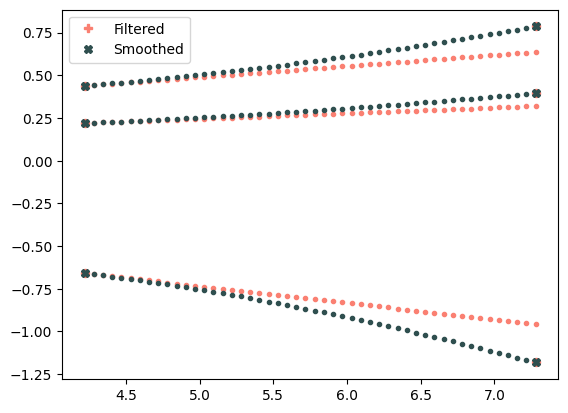

In [9]:
plt.plot(
    dense.t,
    dense.marginals_filtered.mean[:, -2, :],
    ".",
    color="salmon",
    label="Filtered",
)
plt.plot(
    dense.t,
    dense.marginals.mean[:, -2, :],
    ".",
    color="darkslategray",
    label="Smoothed",
)
plt.plot(
    solution_small.t,
    solution_small.marginals_filtered.mean[:, -2, :],
    "P",
    color="salmon",
    label="Filtered",
)
plt.plot(
    solution_small.t,
    solution_small.marginals.mean[:, -2, :],
    "X",
    color="darkslategray",
    label="Smoothed",
)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()